In [1]:
import cv2 as cv2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from update_DB import Update_DB
from query import Thumbnails

In [3]:
udb = Update_DB()
udb.preprocess_data()
fm = udb.get_features('fc8')
print(fm.shape)
fm

(0, 1000)


array([], shape=(0, 1000), dtype=float64)

/usr/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


0
0
0


IndexError: index 0 is out of bounds for axis 0 with size 0

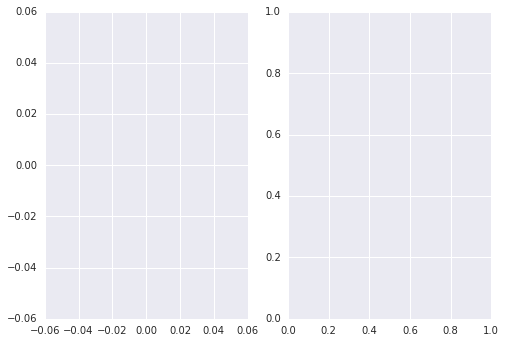

In [3]:
import itertools
import seaborn as sns

num_img = fm.shape[0]
print(num_img)
# number of possible combinations 
num_comb = (num_img)*(num_img-1)/2
num_perm = (num_img)*(num_img-1)
print(num_comb)
print(num_perm)

def _calc_rmse(fm1, fm2):
    return np.sqrt(np.mean(fm1-fm2)**2)

vect_comb = np.zeros([num_comb,3])
comb_matrix = np.zeros([num_img,num_img])
for i, comb in enumerate(itertools.combinations(np.arange(num_img), 2)):
    vect_comb[i,0:2] = np.array(comb)
    rmse   = _calc_rmse(fm[comb[0],:],fm[comb[1],:])
    vect_comb[i,2]   = rmse
    comb_matrix[comb[0],comb[1]] = rmse
    comb_matrix[comb[1],comb[0]] = rmse

vect_perm = np.zeros([num_perm,3])
for i, perm in enumerate(itertools.permutations(np.arange(num_img), 2)):
    vect_perm[i,0:2] = np.array(perm)
    vect_perm[i,2]   = _calc_rmse(fm[perm[0],:],fm[perm[1],:])

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(vect_comb[:,2][:])
ax2.boxplot(vect_comb[:,2][:])
plt.show()

comb_df = pd.DataFrame(comb_matrix)

fm_plot = sns.heatmap(comb_matrix,  xticklabels = 10, yticklabels = 10, cmap = 'viridis')
fm_plot.set(xlabel='image number', ylabel='image number', title = 'euclidean distance between images')
fig = fm_plot.get_figure()
fig.savefig('feature_map_plot.png')


In [46]:
# get similar combinations list
std_fm = np.std(vect_comb[:,2])
mean_fm = np.mean(vect_comb[:,2])
print('MEAN: %.2f, STD: %.2f' % (mean_fm, std_fm)))

fm_df = pd.DataFrame(vect_comb[:,:])
fm_df.dtypes
fm_df[[0,1]] = fm_df[[0,1]].astype(int)
comb_similar = fm_df.loc[fm_df[2] <  (mean_fm-2.5*std_fm)]
comb_similar.shape
comb_similar
# np.unique(comb_similar[0:2])

0.654924483911
3.36999914332


,0,1,2
17,0,18,1.618533
313,3,5,1.674739
380,3,72,1.501238
383,3,75,1.511286
1166,11,78,1.680856
1208,12,27,1.499014
1323,13,50,1.685757
1336,13,63,1.494403
1373,13,100,1.432828
2014,21,41,1.628571


In [119]:
mean_fm-2.5*std_fm

1.7326879335456939

In [48]:
# get similar permutations list
fm_df = pd.DataFrame(vect_perm[:,:])
fm_df.dtypes
fm_df[[0,1]] = fm_df[[0,1]].astype(int)
perm_similar = fm_df.loc[fm_df[2] <  (mean_fm-2.5*std_fm)]
perm_similar.shape
perm_similar
# np.unique(comb_similar[0:2])

,0,1,2
17,0,18,1.618533
319,3,5,1.674739
386,3,72,1.501238
389,3,75,1.511286
528,5,3,1.674739
1232,11,78,1.680856
1286,12,27,1.499014
1414,13,50,1.685757
1427,13,63,1.494403
1464,13,100,1.432828


In [76]:
type(perm_similar)
perm_similar[0].unique()

int(perm_similar[perm_similar[0] == 13].values[1, 0])

unique_original_lst = perm_similar[0].unique()
unique_original_lst[5]

13

In [121]:
# plt.imshow(udb.images[0])
# plt.imshow(udb.images[1][0])
def get_filename_lst(similar_df):
    unique_original_lst = similar_df[0].unique()
    filenames_lst = []
    
    for unique_idx in unique_original_lst:      
        # similar indexes
        original_idx = unique_idx
#         print(original_idx)
        similar_idxs = [int(i) for i in similar_df[similar_df[0] == unique_idx].values[:, 1] ]
#         print(similar_idxs)
        # similar filenames
        similar_fnms_lst = [udb.img_filenames[original_idx]]
        similar_fnms_lst.extend([udb.img_filenames[idx] for idx in similar_idxs] )
#         print(similar_fnms_lst)

        filenames_lst.append(similar_fnms_lst)
    
    return filenames_lst

In [122]:
print(get_filename_lst(perm_similar))


NameError: global name 'filenames_lst' is not defined

In [120]:
prev_fnm_lst = get_similar_img(perm_similar)

for img_lst in prev_fnm_lst:
    prev = Thumbnails(227, 2, 5)
    prev.create_preview( img_lst )
    prev.save_to_file('similar_to_' + img_lst[0] + '.png')